In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf

# Prepare training and testing data

In [2]:
with open('normalized_banknote.csv') as f:
    temp = np.loadtxt(f, delimiter=',', skiprows=1)

X = temp[:,:-1]
y = temp[:,-1]
X = MinMaxScaler().fit_transform(X)
y = np.tensor([-1 if i == 0 else 1 for i in y])

num_data = len(y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = X[index[:num_train]]
Y_train = y[index[:num_train]]
feats_val = X[index[num_train:]]
Y_val = y[index[num_train:]]

In [3]:
X.shape

(1371, 4)

In [4]:
y.shape

(1371,)

# define varational circuit

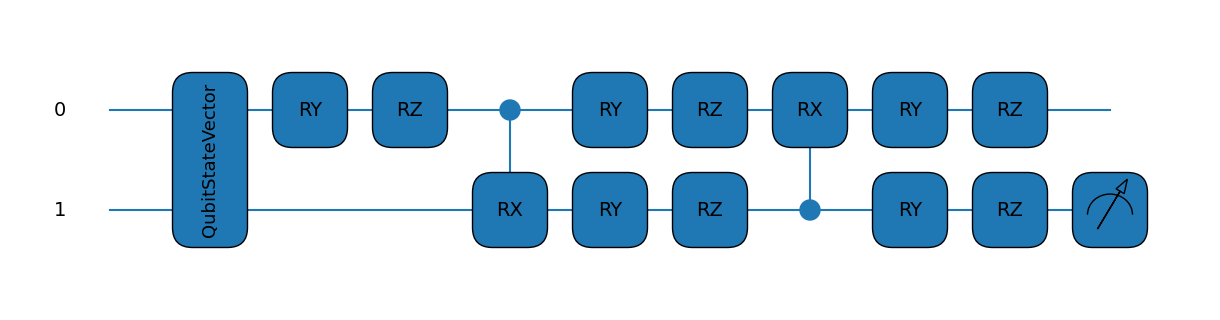

In [17]:
num_wires = 2
dev = qml.device("default.qubit", wires=num_wires)

@qml.qnode(dev, diff_method="backprop")
def circuit(feature_vector,weights=None):
    qml.AmplitudeEmbedding(features=feature_vector, wires=range(num_wires), pad_with=0,normalize=True)
    qml.RY(weights[0], wires=0)
    qml.RZ(weights[1], wires=0)

    qml.CRX(weights[2],wires=[0,1])
    qml.RY(weights[3], wires=0)
    qml.RZ(weights[4], wires=0)
    qml.RY(weights[5], wires=1)
    qml.RZ(weights[6], wires=1)

    qml.CRX(weights[7],wires=[1,0])
    qml.RY(weights[8], wires=0)
    qml.RZ(weights[9], wires=0)
    qml.RY(weights[10], wires=1)
    qml.RZ(weights[11], wires=1)
    return qml.expval(qml.PauliZ(wires=1))
weights = np.array([1.69783, -0.0349, 1.09658, -0.67087, 0.56437, 0.09912, 1.62751, 2.22998, 0.16848, 0.58332, 1.84687, 0.81434], requires_grad=True)
# weights = np.random.random(size=[12], requires_grad=True)
bias = np.array(0.15, requires_grad=True)
# bias = np.array(0.0, requires_grad=True)
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(feats_train[0],weights)

In [18]:
def variational_classifier(weights, bias,feature_vector):
    return circuit( feature_vector,weights)+bias

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias,f) for f in features]
    loss = 0
    for l, p in zip(labels, predictions):
        loss +=  (l - p) ** 2
    return loss/ len(labels)

def accuracy(labels, predictions):
    success = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 0.5:
            success += 1
    return success/ len(labels)

In [19]:
opt = NesterovMomentumOptimizer(stepsize=0.02)

def mini_batch_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

num_epochs = 100
batch_size = 20
for epoch in range(num_epochs):
    for feats_train_batch, Y_train_batch in mini_batch_iter(batch_size, feats_train, Y_train):
        feats_train_batch = feats_train_batch.numpy()
        Y_train_batch = Y_train_batch.numpy()
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias,feats_train_batch , Y_train_batch)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    print(
        "Epoch: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(epoch + 1, cost(weights, bias, X, y), acc_train, acc_val)+str([ float("{:.5f}".format(elem)) for elem in weights.flatten().tolist() ])+str( float("{:.5f}".format(bias)))
    )

Epoch:     1 | Cost: 0.6911466 | Acc train: 0.7723735 | Acc validation: 0.7551020 [1.71057, -0.03504, 1.11471, -0.75758, 0.52344, 0.14302, 1.55942, 2.25629, 0.16848, 0.58332, 1.79646, 0.81434]0.01632
Epoch:     2 | Cost: 0.6846506 | Acc train: 0.7801556 | Acc validation: 0.7609329 [1.78757, -0.01074, 1.15775, -0.78782, 0.54292, 0.08664, 1.56305, 2.26399, 0.16848, 0.58332, 1.77801, 0.81434]0.02875
Epoch:     3 | Cost: 0.6761846 | Acc train: 0.8501946 | Acc validation: 0.8134111 [1.84181, -0.00484, 1.19435, -0.83851, 0.52285, 0.17932, 1.64805, 2.21442, 0.16848, 0.58332, 1.79805, 0.81434]0.09279
Epoch:     4 | Cost: 0.6896897 | Acc train: 0.7675097 | Acc validation: 0.7551020 [1.84798, 0.00557, 1.22841, -0.9046, 0.5018, 0.08578, 1.58518, 2.24869, 0.16848, 0.58332, 1.74498, 0.81434]0.01938
Epoch:     5 | Cost: 0.6816675 | Acc train: 0.7850195 | Acc validation: 0.7638484 [1.87786, 0.02467, 1.29208, -0.95426, 0.50137, 0.09759, 1.62195, 2.21966, 0.16848, 0.58332, 1.75158, 0.81434]0.02385
Epoc

KeyboardInterrupt: 